# Clustering 
1. Hierarchical clustering
2. K-means clustering
3. DBScanner clustering

#### Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth 
from sklearn.neighbors import NearestNeighbors 
from sklearn.mixture import GaussianMixture 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.spatial.distance import pdist, squareform
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('Processed_Data.csv')

In [3]:
df.head(5)

,vendor_count,is_chain,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,CUI_Chicken Dishes,CUI_Chinese,CUI_Desserts,CUI_Healthy,...,CUI_Japanese,CUI_Noodle Dishes,CUI_OTHER,CUI_Street Food / Snacks,CUI_Thai,engagement_duration,tot_value_cui,preferred_order_day,preferred_order_hour,age_category
0,2.0,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,28.88,0,18,26
1,2.0,2.0,12.82,6.39,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,19.21,0,10,16
2,1.0,2.0,9.20,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,9.20,0,9,42
3,2.0,1.0,0.00,13.70,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,31.56,1,11,26
4,2.0,0.0,14.57,40.87,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2,55.44,1,8,26


In [10]:
cluster_features = ['vendor_count', 'is_chain', 
                                       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
                                       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 
                                       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 
                                       'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 
                                       'CUI_Thai', 'engagement_duration', 'tot_value_cui', 
                                       'preferred_order_day', 'preferred_order_hour', 
                                       'age_category']

print('cluster_features', cluster_features)

cluster_features ['vendor_count', 'is_chain', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'engagement_duration', 'tot_value_cui', 'preferred_order_day', 'preferred_order_hour', 'age_category']


In [5]:
print(df[cluster_features].dtypes)

vendor_count                float64
is_chain                    float64
CUI_American                float64
CUI_Asian                   float64
CUI_Beverages               float64
CUI_Cafe                    float64
CUI_Chicken Dishes          float64
CUI_Chinese                 float64
CUI_Desserts                float64
CUI_Healthy                 float64
CUI_Indian                  float64
CUI_Italian                 float64
CUI_Japanese                float64
CUI_Noodle Dishes           float64
CUI_OTHER                   float64
CUI_Street Food / Snacks    float64
CUI_Thai                    float64
engagement_duration           int64
tot_value_cui               float64
preferred_order_day           int64
preferred_order_hour          int64
age_category                  int64
dtype: object


With this we can confirm that all features features are numeric (`float64` and `int64`)

In [6]:
print(df.shape)  

(31875, 22)


In [7]:
print(cluster_features) 

['vendor_count', 'is_chain', 'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'engagement_duration', 'tot_value_cui', 'preferred_order_day', 'preferred_order_hour', 'age_category']


### Hierarchical Clustering 

Linkage Matrix

In [8]:
linkage_matrix = linkage(df[cluster_features].to_numpy(), method='ward')

Dendrogram

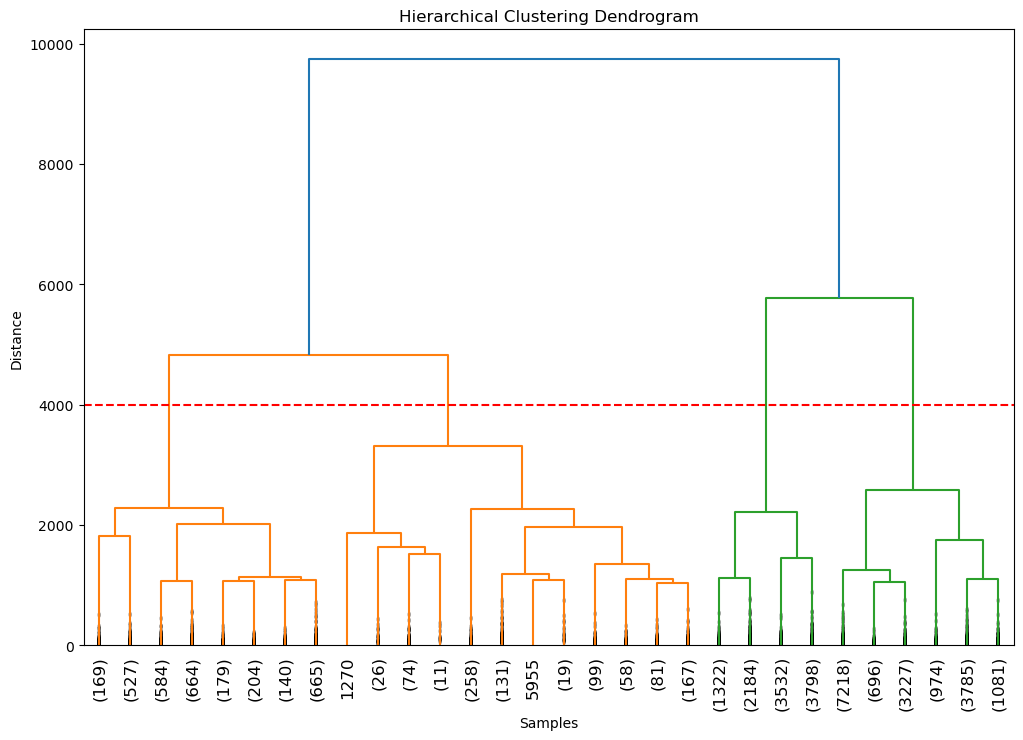

In [14]:
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  
    p=30, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True)

plt.axhline(y=4000, color='r', linestyle='--') 

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

Number of clusters

In [15]:
cluster_labels = fcluster(linkage_matrix, t=4000, criterion='distance')

In [16]:
df['Cluster'] = cluster_labels
print(df['Cluster'].value_counts())

Cluster
4    16981
3    10836
1     3132
2      926
Name: count, dtype: int64


##### 1. Dendrogram
The dendrogram was generated using the **Ward's Linkage** method, which minimizes the variation within clusters. 
- The red line represents the **cut-off height** defined at `t=4000`.
- This line determines the number of clusters by "cutting" the dendrogram.
- The branches below the red line correspond to the formed clusters.

##### 2. Clusters
**5 clusters** were identified, with the following sizes:

| Cluster | Number of Samples |
|---------|--------------------|
| 1       | 3132                |
| 2       | 926             |
| 3       | 10836             |
| 4       | 16981             |


### Cluster Analysis: 
The following variables were analyzed across clusters:
- `vendor_count`
- `is_chain`
- `first_order`
- `last_order`
- `engagement_duration`
- `tot_value_cui`
- `preferred_order_day`
- `preferred_order_hour`
- `age_category`

This analysis focuses on identifying patterns and differences in these variables among the clusters.

In [19]:
# Agrupar os dados por Cluster e calcular estatísticas básicas
cluster_summary = df.groupby('Cluster').agg({
    'vendor_count': 'mean',
    'is_chain': 'mean',
    'engagement_duration': 'mean',
    'tot_value_cui': 'mean',
    'preferred_order_day': lambda x: x.mode()[0],  # Moda
    'preferred_order_hour': lambda x: x.mode()[0],  # Moda
    'age_category': lambda x: x.mode()[0],  # Moda
    'CUI_American': 'mean',
    'CUI_Asian': 'mean',
    'CUI_Italian': 'mean'
})

# Exibir o resumo dos clusters
print("Resumo dos Clusters:")
print(cluster_summary)


Resumo dos Clusters:
         vendor_count   is_chain  engagement_duration  tot_value_cui  \
Cluster                                                                
1            5.818327   5.490741            61.856641     101.104492   
2            9.340173  10.089633            75.097192     217.318672   
3            3.824197   3.766242            60.520487      32.646971   
4            1.800247   1.325953            12.132442      20.553648   

         preferred_order_day  preferred_order_hour  age_category  \
Cluster                                                            
1                          0                    10            26   
2                          1                    10            26   
3                          0                    11            26   
4                          0                    11            26   

         CUI_American  CUI_Asian  CUI_Italian  
Cluster                                        
1           11.563720  29.316133     6.51

In [21]:
# Agrupar os dados pelos clusters hierárquicos e calcular a média de cada variável
hierarchical_cluster_analysis = df.groupby('Cluster')[[
    'vendor_count', 'is_chain', 'engagement_duration', 'tot_value_cui',
    'preferred_order_day', 'preferred_order_hour', 'age_category'
]].mean()

# Temporariamente mostrar todas as colunas no terminal
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Cluster Analysis for Hierarchical Clustering:")
    print(hierarchical_cluster_analysis)


Cluster Analysis for Hierarchical Clustering:
         vendor_count   is_chain  engagement_duration  tot_value_cui  \
Cluster                                                                
1            5.818327   5.490741            61.856641     101.104492   
2            9.340173  10.089633            75.097192     217.318672   
3            3.824197   3.766242            60.520487      32.646971   
4            1.800247   1.325953            12.132442      20.553648   

         preferred_order_day  preferred_order_hour  age_category  
Cluster                                                           
1                   2.668902             10.057471     28.704662  
2                   2.657667             10.482721     29.163067  
3                   2.546142             12.109358     28.557863  
4                   2.755374             11.408515     28.823096  


The following cuisine-related variables were analyzed across clusters:
- `CUI_American`
- `CUI_Asian`
- `CUI_Beverages`
- `CUI_Cafe`
- `CUI_Chicken Dishes`
- `CUI_Chinese`
- `CUI_Healthy`
- `CUI_Indian`
- `CUI_Italian`
- `CUI_Japanese`
- `CUI_Noodle Dishes`
- `CUI_OTHER`
- `CUI_Street Food / Snacks`
- `CUI_Thai`

In [23]:
# Agrupar os dados pelos clusters hierárquicos e calcular a média de cada variável
hierarchical_cluster_analysis = df.groupby('Cluster')[[
    'CUI_American', 'CUI_Asian', 'CUI_Beverages',
    'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
    'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 'CUI_OTHER',
    'CUI_Street Food / Snacks', 'CUI_Thai'
]].mean()

# Temporariamente mostrar todas as colunas no terminal
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Cluster Analysis for Hierarchical Clustering:")
    print(hierarchical_cluster_analysis)


Cluster Analysis for Hierarchical Clustering:
         CUI_American  CUI_Asian  CUI_Beverages  CUI_Cafe  CUI_Chicken Dishes  \
Cluster                                                                         
1           11.563720  29.316133       3.476143  1.590805            1.026731   
2           22.399568  73.049698      11.746663  9.755486            1.382937   
3            5.105914   4.932886       2.652949  0.691540            1.296853   
4            2.542468   6.148665       1.339370  0.237793            0.350040   

         CUI_Chinese  CUI_Desserts  CUI_Healthy  CUI_Indian  CUI_Italian  \
Cluster                                                                    
1           3.852350      2.483605     2.314029    1.530658     6.514033   
2           5.548099      4.894471     5.810054    9.912225    19.146048   
3           1.630819      0.609669     0.989291    2.132466     3.342099   
4           0.633886      0.546677     0.409426    0.879457     1.693706   

         C

### **Cluster Analysis Summary**

| **Cluster** | **Vendor Count** | **Is Chain** | **Engagement Duration** | **Total Value** | **Preferred Order Day** | **Preferred Order Hour** | **Age Category** | **Top Cuisines**                | **Conclusion**                                                                 |
|-------------|------------------|--------------|--------------------------|-----------------|--------------------------|--------------------------|------------------|----------------------------------|--------------------------------------------------------------------------------|
| **1**       | 5.82             | 5.49         | 61.86                   | 101.10          | 2.67                     | 10.06                    | 28.70           | Asian, American, Street Food       | High-spending, engaged customers, mostly aged around 29 years, preferring Asian and Japanese cuisines with morning orders. |
| **2**       | 9.34             | 10.09        | 75.10                   | 217.32          | 2.66                     | 10.48                    | 29.16           | Asian, American, Italian, Japonese and Street Food        | High-value, loyal customers, around 29 years old, with consistent engagement, favoring Asian and Italian cuisines and morning orders. |
| **3**       | 3.82             | 3.77         | 60.52                   | 32.65           | 2.55                     | 12.11                    | 28.56           | Asian, American                 | Price-sensitive customers, moderately engaged, aged around 28 years, preferring Asian cuisine and mid-morning orders. |
| **4**       | 1.80             | 1.33         | 12.13                   | 20.55           | 2.75                     | 11.41                    | 28.82           | Asian, American                 | Low-priority customers, mostly aged 29 years, with low spending and engagement, favoring Asian cuisine and late-morning orders. |


### 2. K-Means ###

In [15]:
# Use cluster_features to select relevant columns from your DataFrame
X = df[cluster_features]  # Select only the specified features

In [16]:
# Define the range of clusters to evaluate
range_clusters = range(2, 11)  # k from 2 to 10

# Store silhouette scores
silhouette_scores = []

for k in range_clusters:
    # Initialize and fit K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmeans.fit_predict(X)  # Use selected features from cluster_features
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")


For n_clusters = 2, the silhouette score is 0.577
For n_clusters = 3, the silhouette score is 0.335
For n_clusters = 4, the silhouette score is 0.328
For n_clusters = 5, the silhouette score is 0.313
For n_clusters = 6, the silhouette score is 0.308
For n_clusters = 7, the silhouette score is 0.314
For n_clusters = 8, the silhouette score is 0.293
For n_clusters = 9, the silhouette score is 0.284
For n_clusters = 10, the silhouette score is 0.226


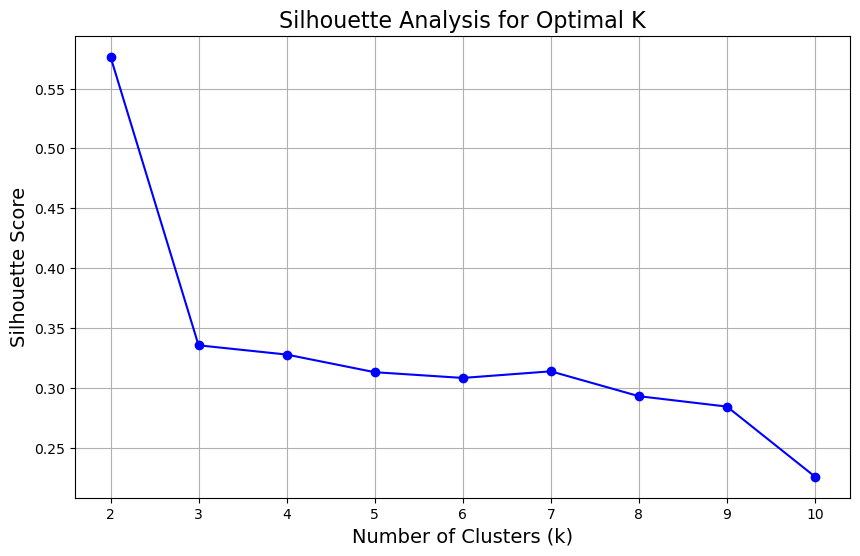

In [17]:
# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title("Silhouette Analysis for Optimal K", fontsize=16)
plt.xlabel("Number of Clusters (k)", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.xticks(range_clusters)
plt.grid(True)
plt.show()


In [18]:
# Perform K-Means with the optimal number of clusters
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', n_init=15, random_state=1)
cluster_labels = kmeans.fit_predict(df[cluster_features])

# Add the cluster labels to your original DataFrame
df['Cluster'] = cluster_labels

# Inspect the number of observations in each cluster
print(df['Cluster'].value_counts())

Cluster
1    28287
0     3588
Name: count, dtype: int64


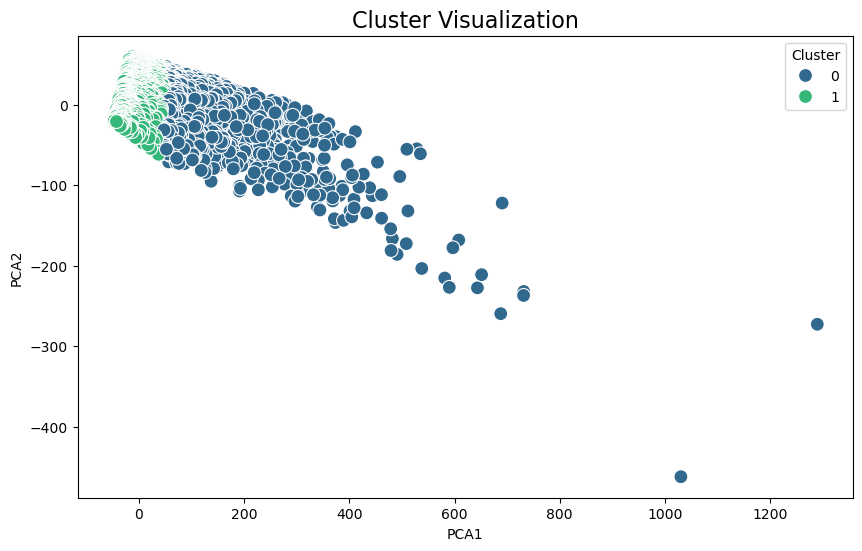

In [19]:
# Reduce to 2 dimensions
pca = PCA(n_components=2, random_state=1)
df['PCA1'] = pca.fit_transform(df[cluster_features])[:, 0]
df['PCA2'] = pca.fit_transform(df[cluster_features])[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=100)
plt.title("Cluster Visualization", fontsize=16)
plt.show()

In [20]:
# Group by the cluster labels and compute the mean of each feature
cluster_analysis = df.groupby('Cluster')[cluster_features].mean()
# Temporarily show all rows and columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(cluster_analysis)


         vendor_count  is_chain  CUI_American  CUI_Asian  CUI_Beverages  \
Cluster                                                                   
0            7.282887  7.353400     15.444760  42.925148       6.681329   
1            2.571853  2.244246      3.536787   5.773322       1.742259   

         CUI_Cafe  CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
Cluster                                                                         
0        3.803657            1.355864     4.850906      3.322458     3.326867   
1        0.420687            0.693895     0.998113      0.575510     0.649177   

         CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  \
Cluster                                                                        
0          4.354688     9.366196     10.065131           1.511285   9.258261   
1          1.286442     2.456998      2.099367           0.610578   2.207466   

         CUI_Street Food / Snacks  CUI_Thai  engageme

| **Cluster** | **Vendor Count** | **Is Chain** | **Engagement Duration** | **Total Value** | **Preferred Order Day** | **Preferred Order Hour** | **Age Category** | **Top Cuisines** | **Conclusion** |
|-------------|------------------|--------------|------------------------|-----------------|------------------------|------------------------|------------------|-----------------|----------------|
| **0** | 7.28 | 7.35 | 68.96 | 136.66 | 2.66 | 10.25 | 28.85 | Asian (42.93), Street Food (17.96), American (15.44) | High-value customers who frequently engage with chain restaurants. They prefer early morning orders and have a strong preference for Asian cuisine and street food. |
| **1** | 2.57 | 2.24 | 31.03 | 25.82 | 2.67 | 11.64 | 28.72 | Asian (5.77), American (3.54), Italian (2.46) | Lower-value customers with less engagement and fewer chain interactions. They tend to order later in the morning and have more moderate cuisine preferences. |

## GMM (Gaussian Mixture Model )

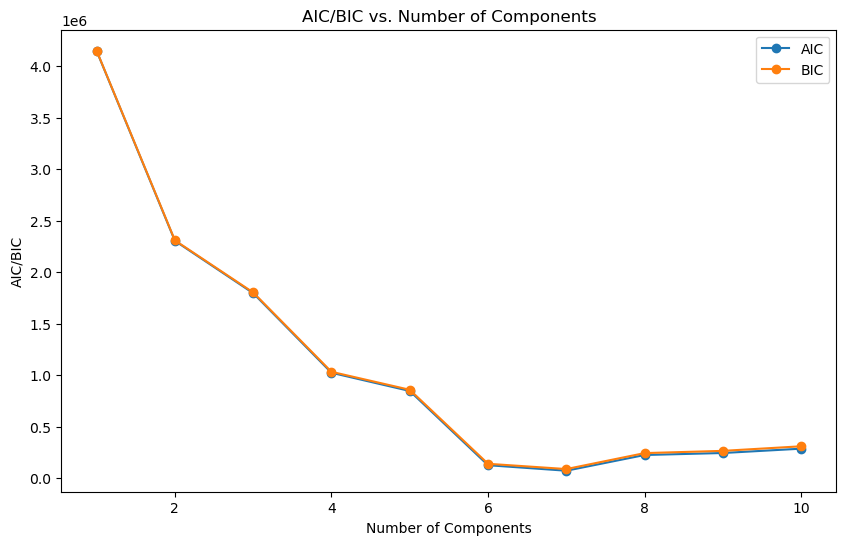

In [4]:
# List to store the AIC and BIC values
aic_values = []
bic_values = []

# Try a range of component numbers (e.g., 1 to 10)
for n_components in range(1, 11):
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(df)  # Use the entire dataset or scaled data
    aic_values.append(gmm.aic(df))  # Add the AIC value
    bic_values.append(gmm.bic(df))  # Add the BIC value

# Plot the AIC and BIC values
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), aic_values, label="AIC", marker='o')
plt.plot(range(1, 11), bic_values, label="BIC", marker='o')
plt.xlabel('Number of Components')
plt.ylabel('AIC/BIC')
plt.title('AIC/BIC vs. Number of Components')
plt.legend()
plt.show()


In [5]:
gmm = GaussianMixture(n_components=2, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df)
labels_proba = gmm.predict_proba(df)

In [6]:
gmm.weights_

array([0.24581365, 0.75418635])

In [7]:
print(f"Cluster assignments: {np.unique(gmm_labels)}")
print(f"Number of data points per cluster: {np.bincount(gmm_labels)}")


Cluster assignments: [0 1]
Number of data points per cluster: [ 7827 24048]


**2 clusters** were identified, with the following sizes:

| Cluster | Number of Samples |
|---------|--------------------|
| 0       | 7827                |
| 1       | 24048             |

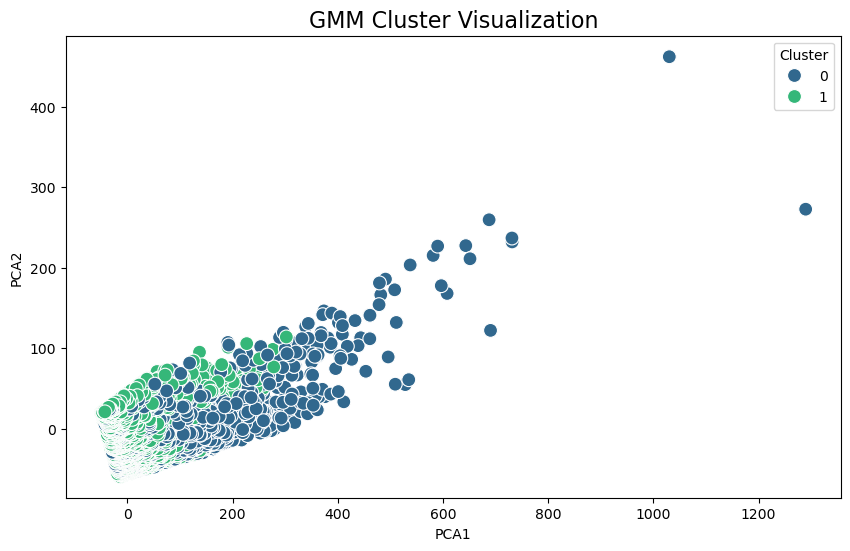

In [11]:
df['Cluster'] = gmm.fit_predict(df[cluster_features])

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2, random_state=1)
df['PCA1'] = pca.fit_transform(df[cluster_features])[:, 0]
df['PCA2'] = pca.fit_transform(df[cluster_features])[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=100)
plt.title("GMM Cluster Visualization", fontsize=16)
plt.show()


In [12]:
# Group by the GMM cluster labels and compute the mean for each feature
cluster_analysis = df.assign(Cluster=gmm_labels).groupby('Cluster')[cluster_features].mean()

# Temporarily show all rows and columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(cluster_analysis)


         vendor_count  is_chain  CUI_American  CUI_Asian  CUI_Beverages  \
Cluster                                                                   
0            5.093267  5.472339      5.662852  11.233203       3.336288   
1            2.454092  1.955880      4.621497   9.539384       1.960361   

         CUI_Cafe  CUI_Chicken Dishes  CUI_Chinese  CUI_Desserts  CUI_Healthy  \
Cluster                                                                         
0        3.264019            1.618862     3.313728      3.602968     3.871224   
1        0.000000            0.491609     0.819283      0.000000     0.000000   

         CUI_Indian  CUI_Italian  CUI_Japanese  CUI_Noodle Dishes  CUI_OTHER  \
Cluster                                                                        
0          2.906733     3.946189      4.470153            2.89944   5.988245   
1          1.216866     3.003168      2.516242            0.00000   2.028911   

         CUI_Street Food / Snacks  CUI_Thai  engageme

### **Cluster Analysis Summary**

| **Cluster** | **Vendor Count** | **Is Chain** | **Engagement Duration** | **Total Value** | **Preferred Order Day** | **Preferred Order Hour** | **Age Category** | **Top Cuisines**                                          | **Conclusion**                                                                                                                                       |
|-------------|------------------|--------------|--------------------------|------------------|--------------------------|---------------------------|------------------|-----------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------|
| **0**       | 5.09             | 5.47         | 50.60                   | 62.02            | 2.61                     | 11.48                     | 28.73           | Asian (11.23), American (5.66), Other (5.99)              | Moderately engaged customers with average spending. They show a preference for Asian, American, and other cuisines, with late-morning orders.         |
| **1**       | 2.45             | 1.96         | 30.32                   | 30.57            | 2.69                     | 11.49                     | 28.73           | Asian (9.54), American (4.62), Italian (3.00)             | Lower-spending, less engaged customers. They prefer Asian, American, and Italian cuisines and tend to order during late-morning hours.                |
